# EIO - K-means

Authors: Dariusz Max Adamski (nr indeksu 136674), Sławomir Gilewski (nr indeksu 142192)

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
sns.set_style('darkgrid')
plt.rc('figure', figsize=(12, 8), dpi=200)

## 1. K-means implementation

Our k-means implementation is incredibly simple - in part because of the vectorized operations. The code is practically identical to the following description: 

1. Sample the initial $k$ means from a uniform distribution, limited by the min and max values of each dimension
1. For up to maximum $n$ iterations, do the next steps
1. For each data point, compute it's closest mean by Euclidean distance
1. Set the centroids of data point clusters as the next means (if a cluster is empty, assign the previous mean)
1. Stop the algorithm, if the change in each mean from the last iteration is less than $\epsilon$

In [2]:
def euclid(a, b, axis=1):
    return np.sqrt(np.sum((a - b)**2, axis=axis))

def kmeans(X, k=3, eps=1e-6, max_iter=100, distance=euclid):
    points = last_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=(k, X.shape[1]))
    for i in range(max_iter):
        labels = np.argmin([distance(X, points[i]) for i in range(k)], axis=0)
        points = np.array([np.mean(X[labels == i], axis=0) if np.sum(labels == i) else points[i] for i in range(k)])
        if np.all(np.abs(last_points - points) < eps):
            print(f'info: k-means early stopping after {i} iterations')
            break
        last_points = points
    return labels, points

One of the ways to test if we have implemented the algorithm correctly is to compare it to a reference implementation. Below we compare results of clustering the "mouse" and "lines" datasets, with $k = 3$, using the implementation provided by `scikit-learn` (visualized on the left) and our implementation (on the right). Other algorithm parameters are the same.

info: k-means early stopping after 17 iterations
Scikit 97.00ms	Ours 4.42ms
info: k-means early stopping after 24 iterations
Scikit 24.43ms	Ours 4.53ms


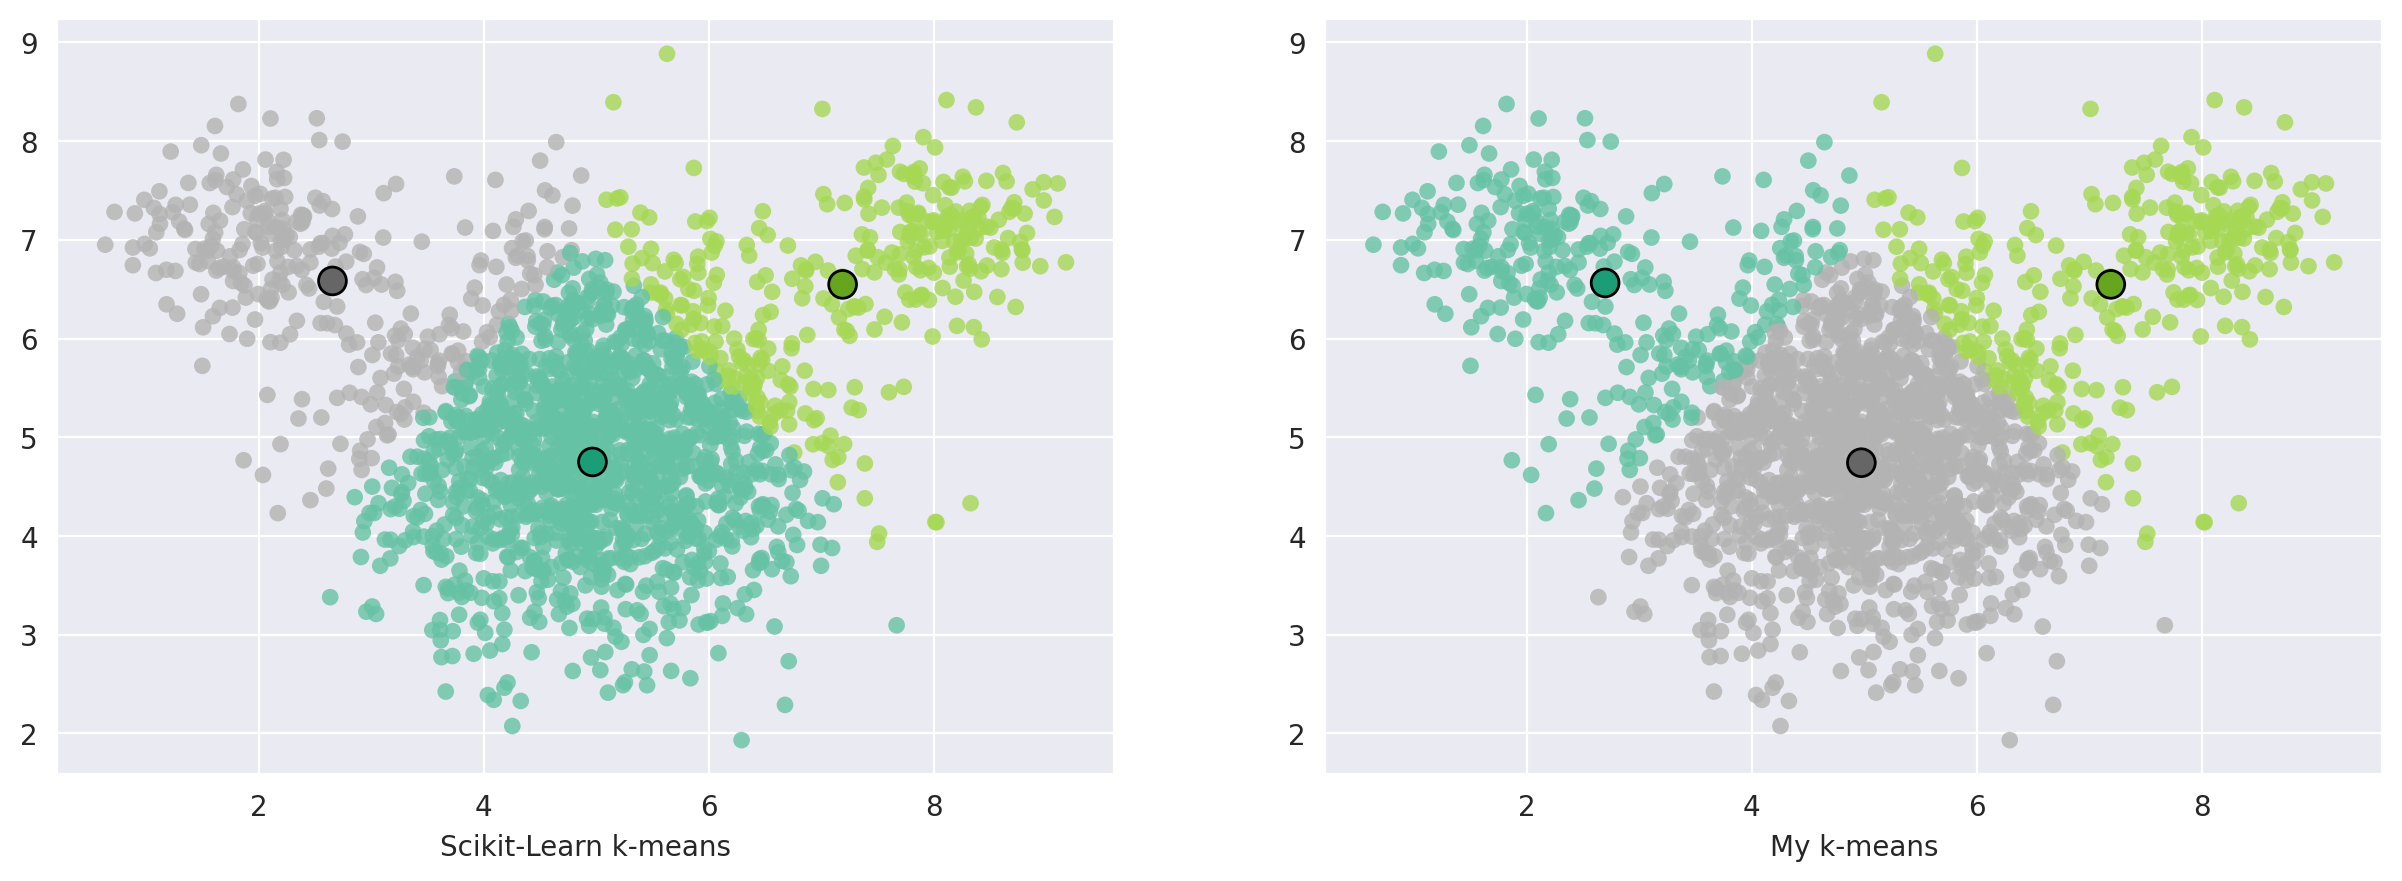

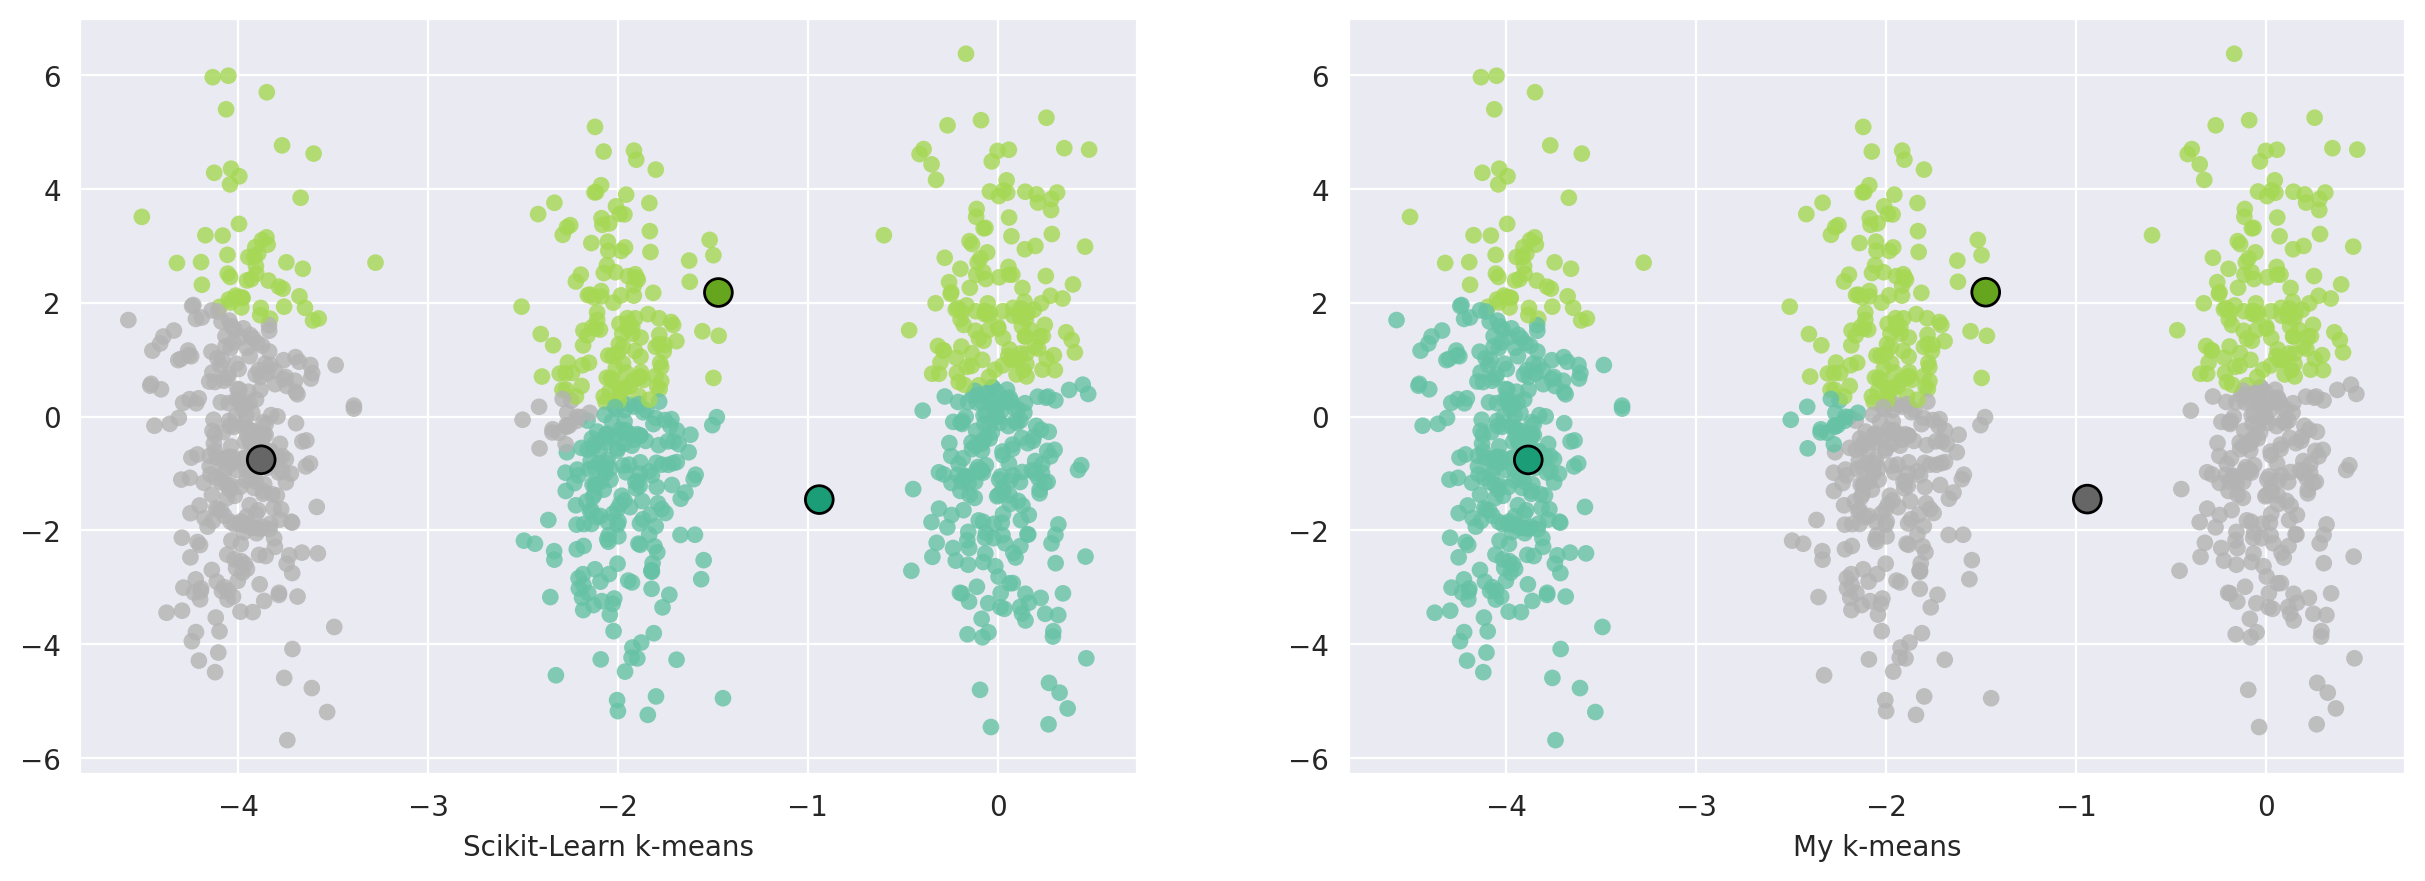

In [11]:
def compare_kmeans(data):
    from sklearn.cluster import KMeans
    from time import time
    k, max_iter, eps, seed = 3, 200, 1e-4, 42
    clus = KMeans(init='random', n_clusters=k, max_iter=max_iter, tol=eps)
    res = []
    np.random.seed(seed)
    t0 = time()
    sk = clus.fit_predict(data)
    t0 = time() - t0
    res.append([sk, clus.cluster_centers_])
    t1 = time()
    res.append(kmeans(data, k=k, max_iter=max_iter, eps=eps))
    t1 = time() - t1
    print(f'Scikit {t0*1e3:.2f}ms\tOurs {t1*1e3:.2f}ms')
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    names = 'Scikit-Learn k-means', 'My k-means'
    for ax, name, (labels, points) in zip(axs, names, res):
        ax.scatter(*data.T, c=labels, alpha=0.8, lw=0, cmap='Set2')
        ax.scatter(*points.T, c=range(len(points)), s=100, lw=1, marker='o', cmap='Dark2', edgecolors='k')
        ax.set_xlabel(name)

compare_kmeans(pd.read_csv('mouse.csv').values)
compare_kmeans(pd.read_csv('lines.csv').values)

We see that besides group coloring, the output is identical. Thus, we conclude that we implemented the k-means algorithm correctly. Also, see that our implementation is **much faster** than the one in `Scikit-learn`, even with the same parameters!

## 2. Cereal dataset analysis

For the next part of the exercise we will analyze the "cereal" dataset, and perform clustering with our k-means algorithm.

First, we read the dataset, drop unnecessary columns and perform standarization with the `StandardScaler`. Then we remove highly correlated columns ($|\rho| > 0.8$, we drop the column with the lower variance). After preprocessing we plot the correlation matrix and visualize the distributions of the variables with a violin plot.

In [12]:
df = pd.read_csv('cereal.csv')
df.type = df.type.map(lambda x: dict(C=0, H=1)[x])
df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,0,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,0,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,0,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,0,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,0,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,0,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat Chex,R,0,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,0,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


dropping potass, which is correlated with fiber (r = 0.90), and has lower variance


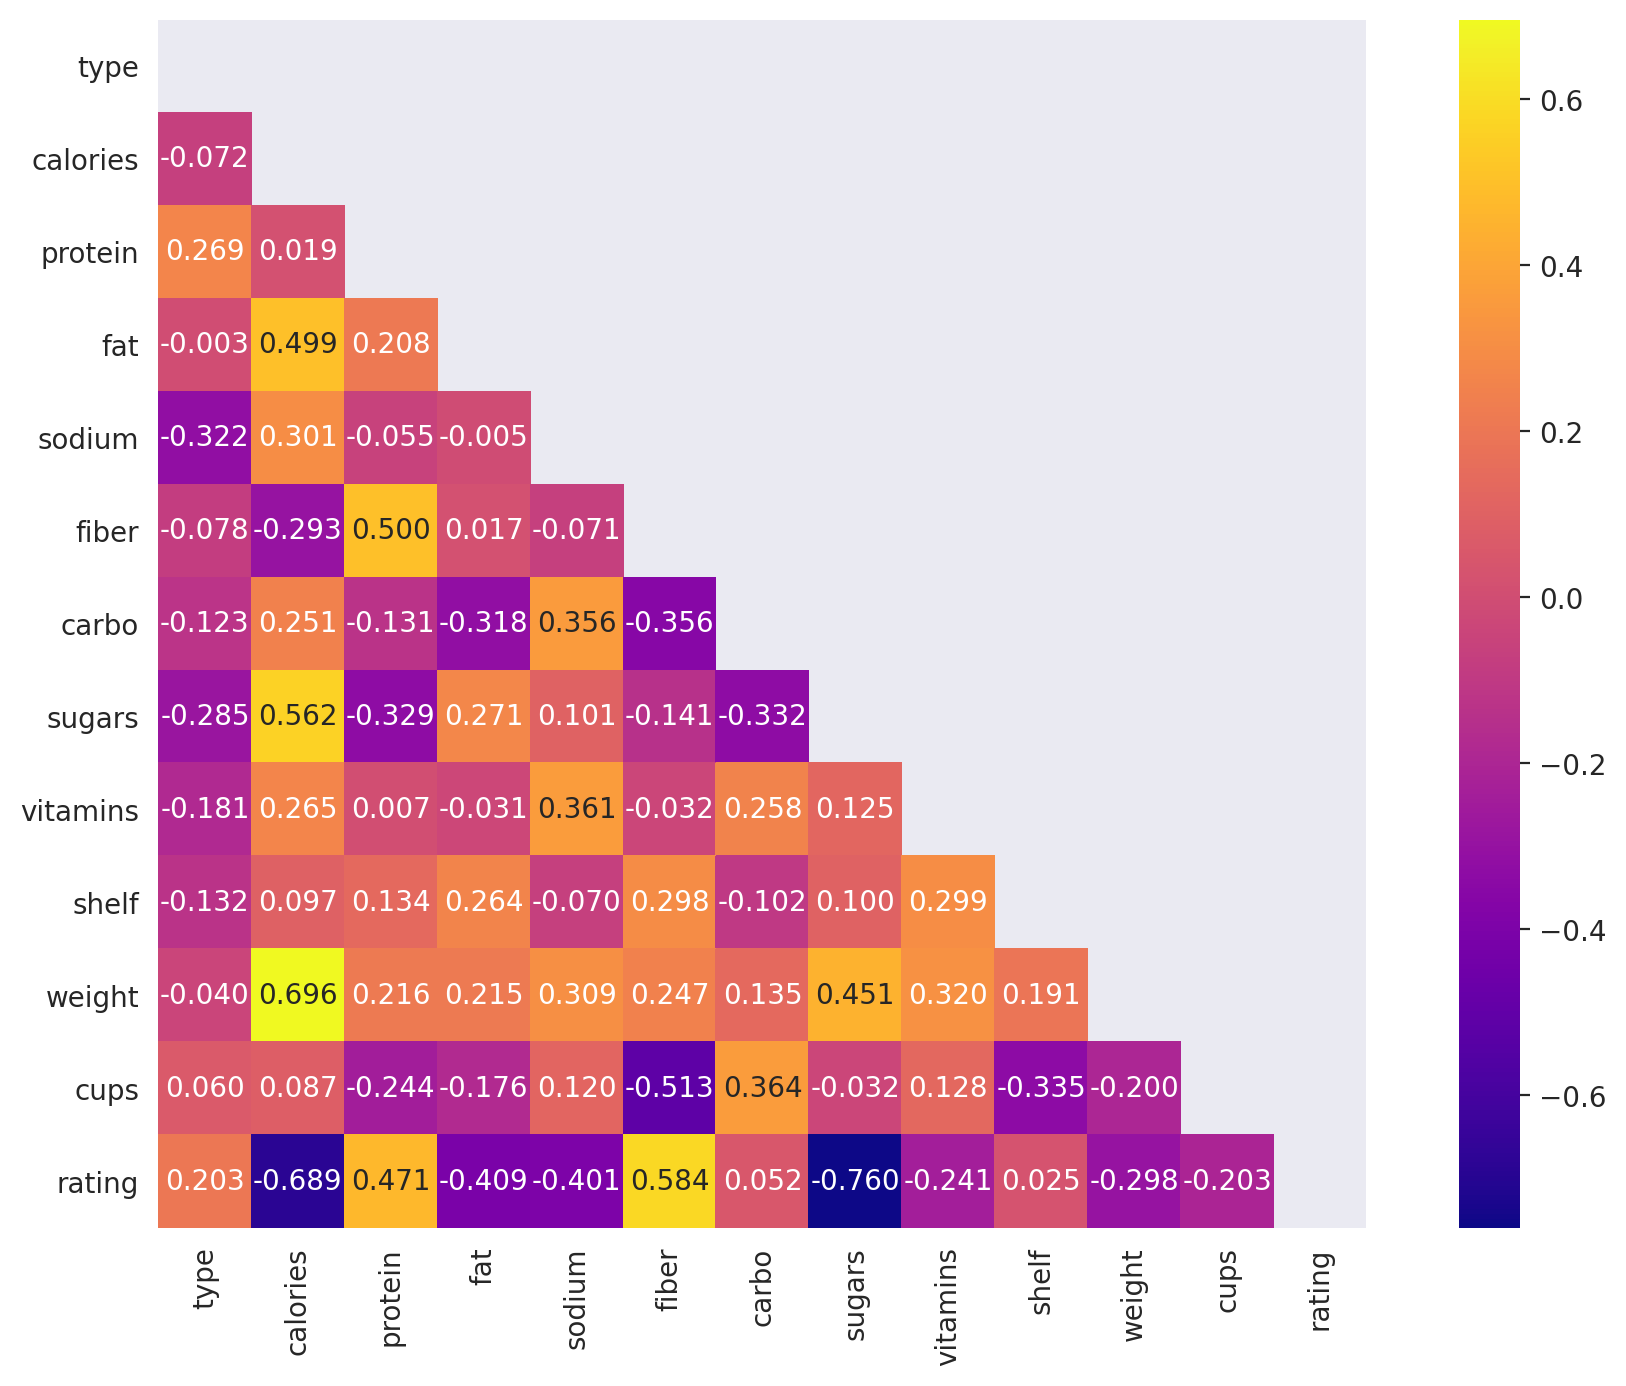

In [13]:
def correlated_columns(df, threshold):
    pairs = []
    for i, a in enumerate(df.columns):
        for j, b in enumerate(df.columns):
            r = np.corrcoef(df[a], df[b])[0,1]
            if i < j and np.abs(r) > threshold:
                pairs.append((a, b, r))
    return pairs

def drop_features(df, threshold):
    for a, b, corr in correlated_columns(df, threshold):
        if a not in df.columns: continue
        if df[a].var() > df[b].var(): a, b = b, a
        print(f'dropping {a}, which is correlated with {b} (r = {corr:.2f}), and has lower variance')
        df.drop(a, axis=1, inplace=True)

X = df.drop(columns=['name', 'mfr'])
X_norm = StandardScaler().fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
drop_features(X_norm, threshold=0.8)
corr = X_norm.corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr), k=0), annot=True, fmt='.3f', square=True, cmap='plasma')
plt.show()

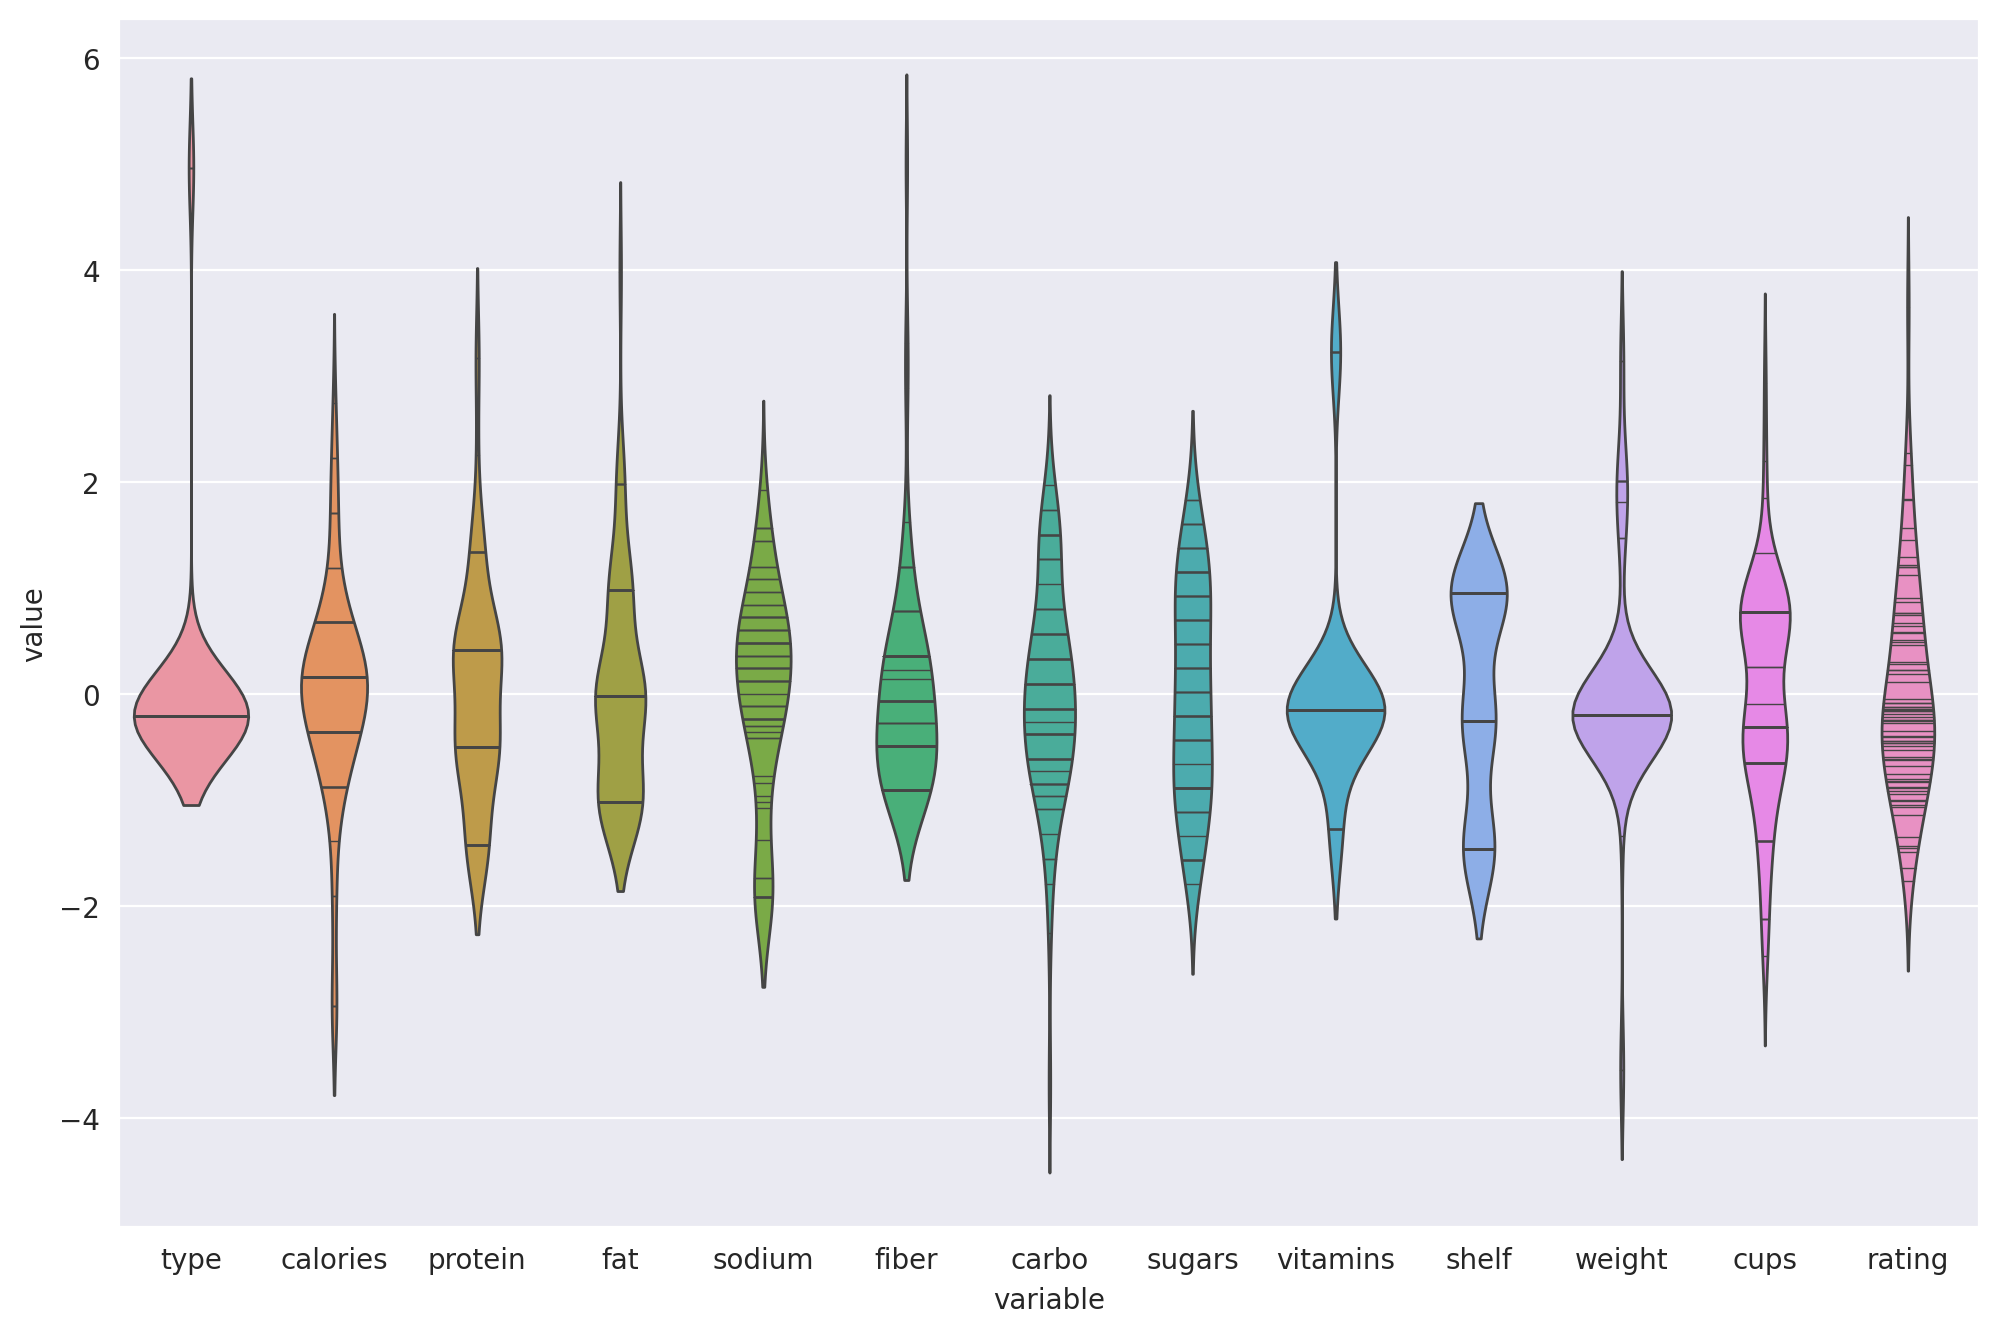

In [14]:
melt = pd.melt(X_norm, var_name='variable', value_name='value')
sns.violinplot(x='variable', y='value', scale='area', inner='stick', data=melt)
plt.show()

Now, let's run the k-means algorithm and print how many items are in each cluster.

In [15]:
np.random.seed(0xCAFE)
labels, clusters = kmeans(X_norm, k=3)
X['cluster'] = labels
for label, count in zip(*np.unique(labels, return_counts=True)):
    print(f'cluster {label}: {count: 3d} items')

info: k-means early stopping after 4 iterations
cluster 0:  57 items
cluster 1:  17 items
cluster 2:   3 items


Now, let's visualize the variables, but this time group values by cluster, and see if there are any commonalities between cereals in the same clusters.

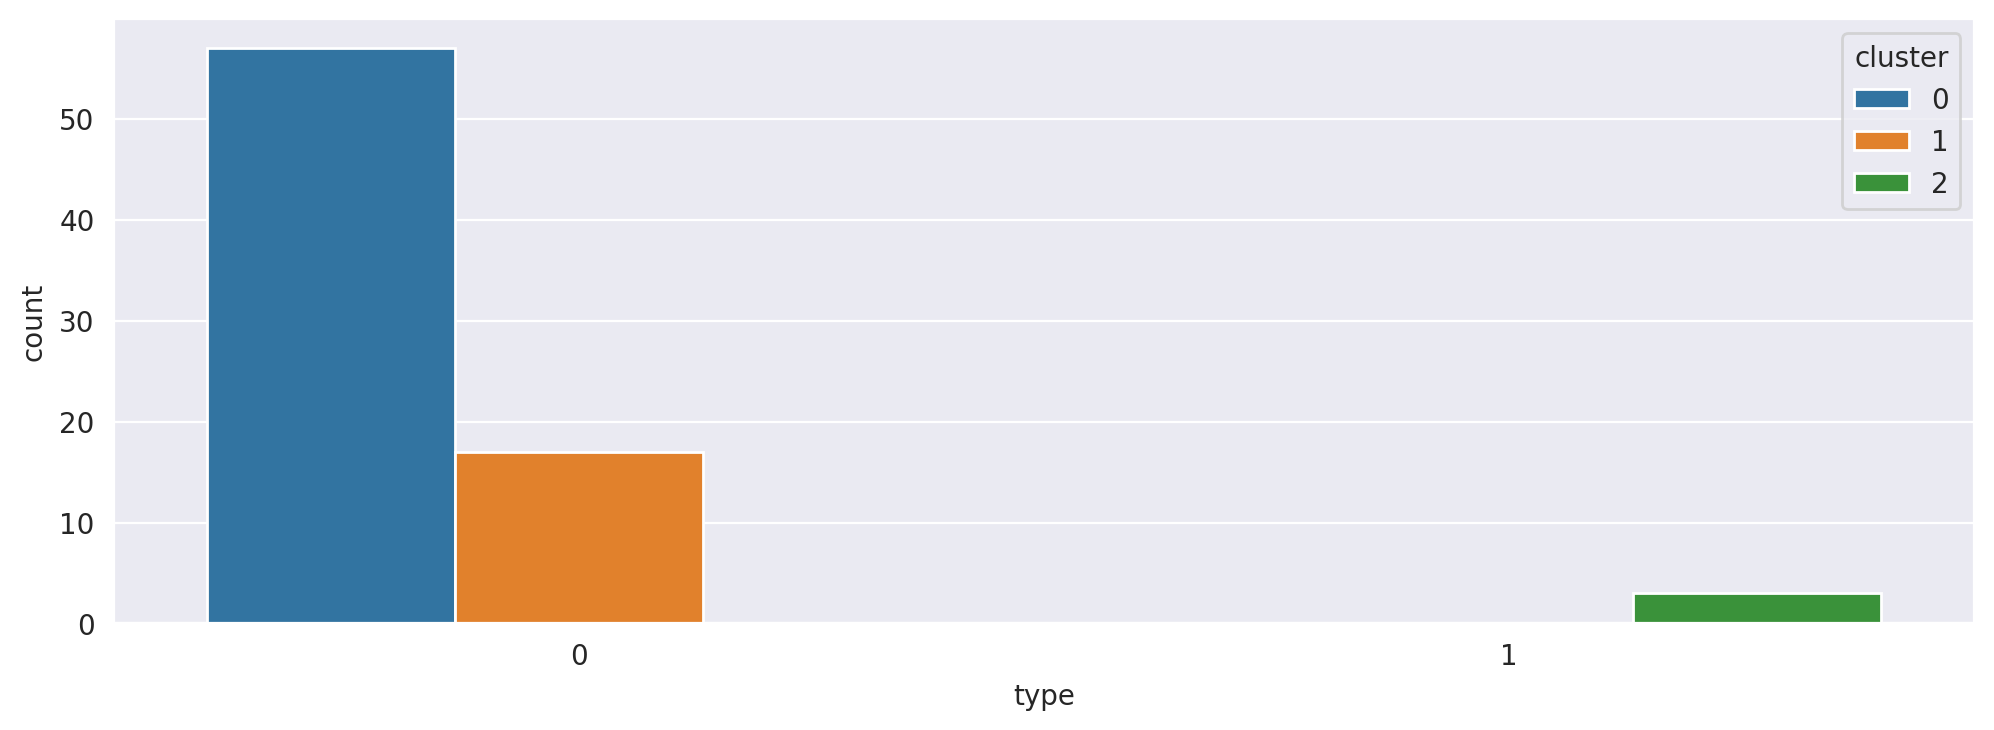

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(x='type', hue='cluster', data=X)
plt.show()

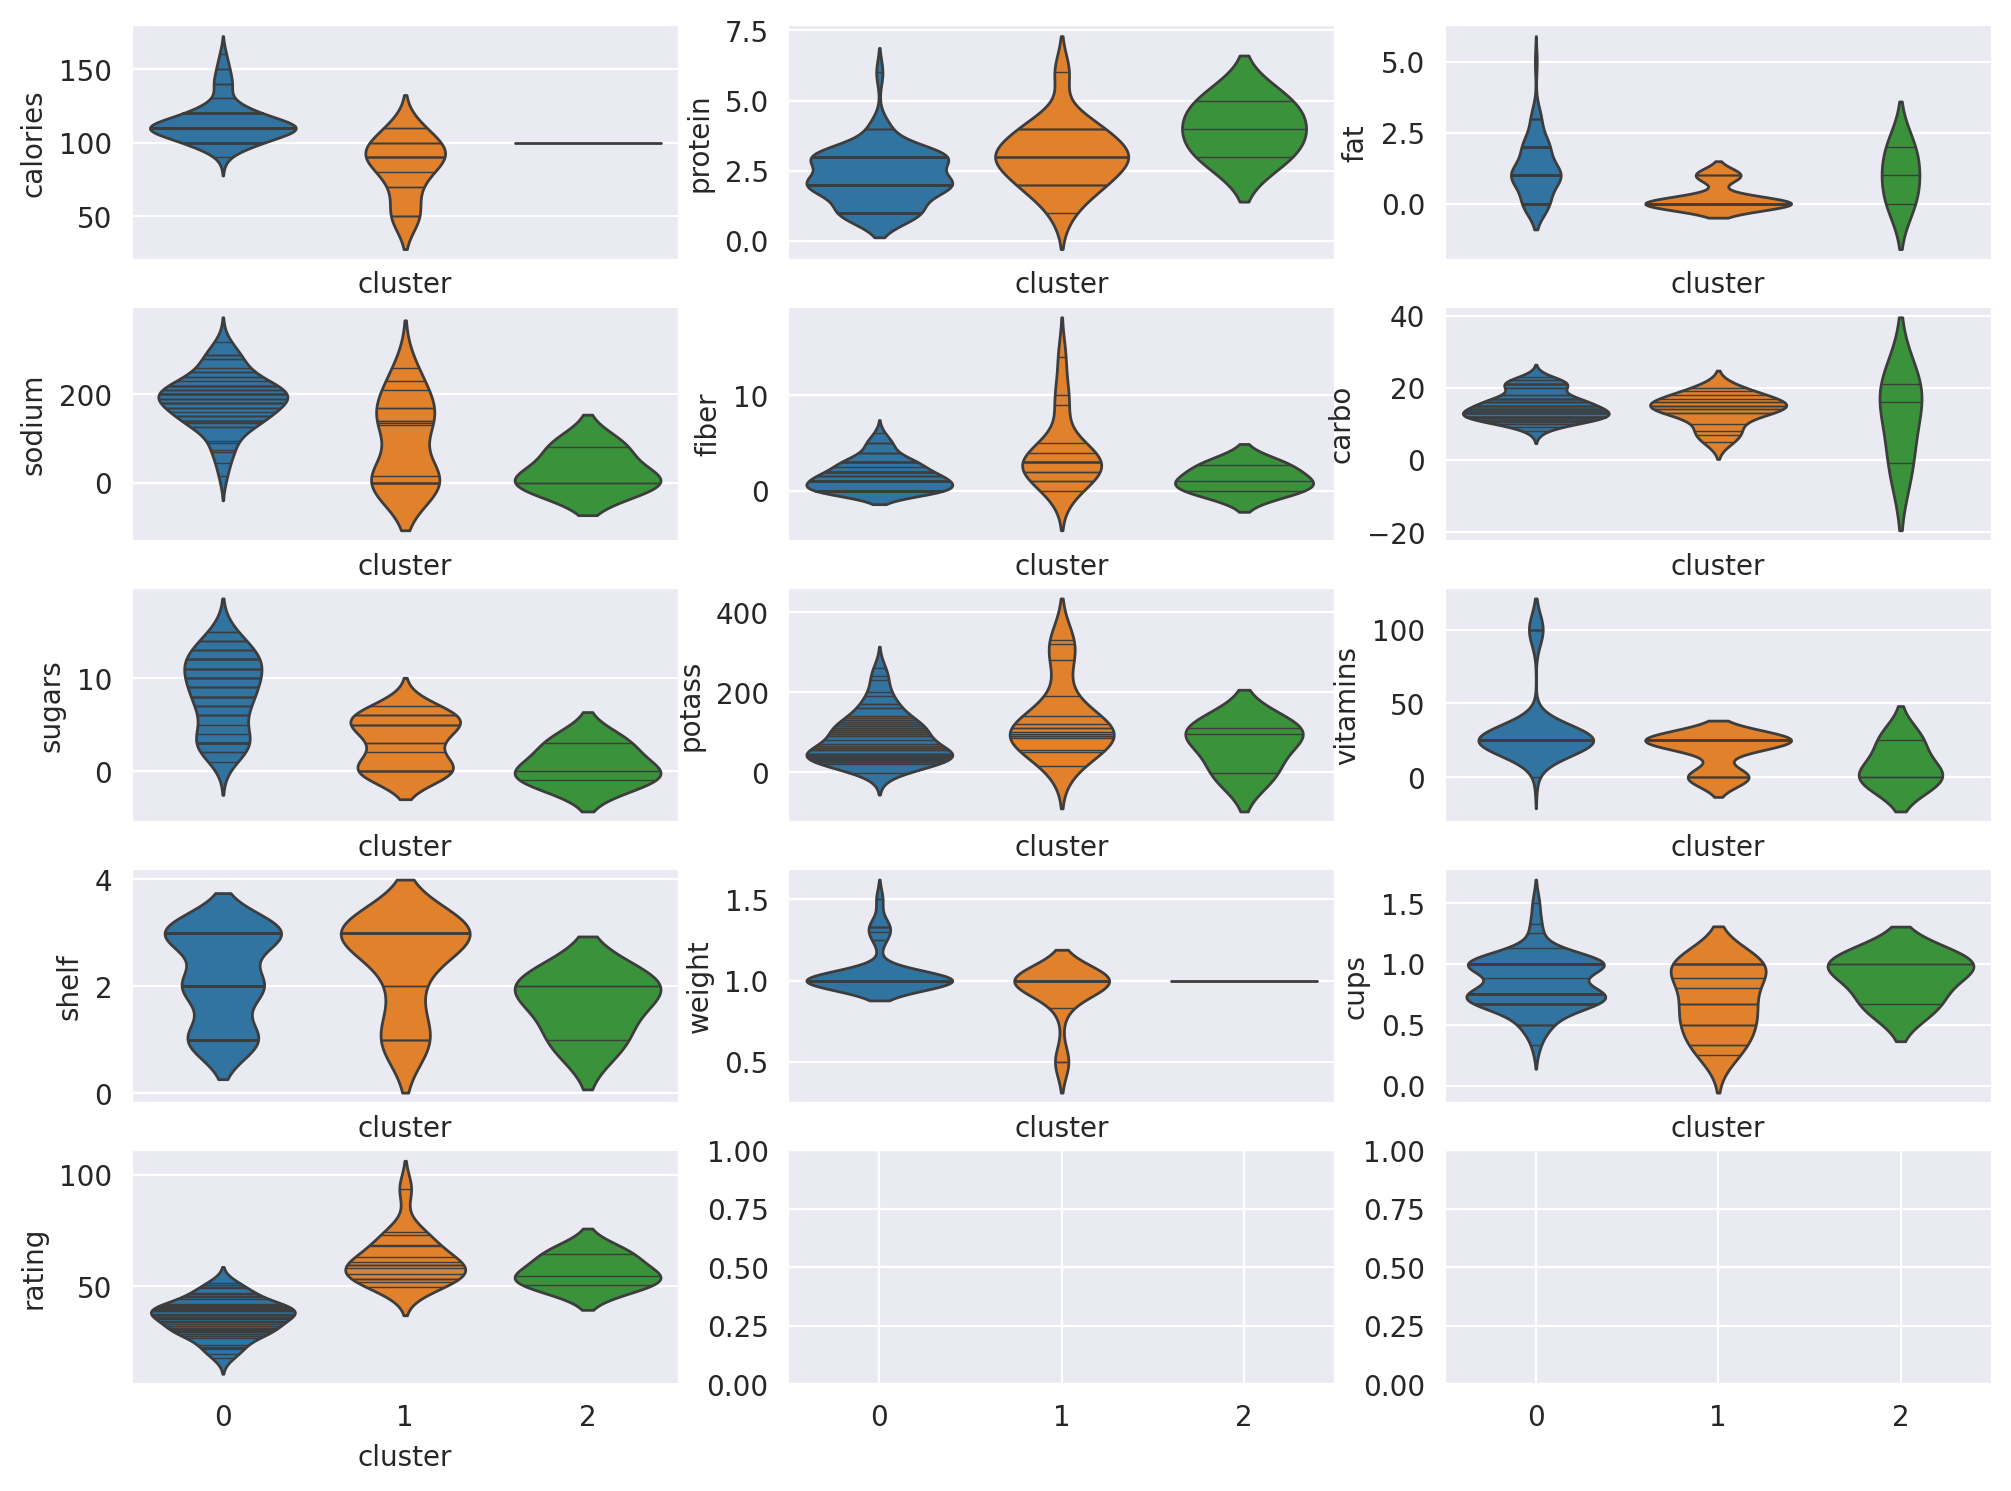

In [17]:
from math import ceil
cols = [x for x in X.columns if x not in ['type', 'cluster']]
fig, axs = plt.subplots(nrows=ceil((len(cols))/3), ncols=3, sharex=True, figsize=(12, 9))
for ax, col in zip(axs.reshape(-1), cols):
    sns.violinplot(x='cluster', y=col, scale='area', inner='stick', data=X, ax=ax)

## 3. Conclusions

- There is one big cluster, one is medium size, and one is very small
- All cereals of type 1 (H) are in cluster 2 
- Cereals in cluster 0 have a lower rating, more sugar and sodium than the rest
- Cereals in cluster 2 have the most protein
- Most cereals in cluster 1 have more protein than cluster 0
- Cereals with little calories, most fiber and potassium are in cluster 1
- Cereals with the highest weight are in cluster 0
- Cereals with the lowest weight are in cluster 1
- Cereals with the most vitamins are in cluster 0
- Cereals with the least and most carbohydres are in cluster 2
- The number of cups does not differ much across clusters 